In [3]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

c:\Users\Nahuel Elias\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Introducción

A partir de los datos brindados por la el Observatorio de Movilidad y Seguridad Vial de la Ciudad de Buenos Aires (OMSV), desde [aqui](https://data.buenosaires.gob.ar/dataset/victimas-siniestros-viales) se descargan archivos en formato xls. Para este trabajo en particular se utilizan los xlsx de homicidios(xlsx). Este archivo consta de dos planillas. Una llamada "hechos" y otra llamada homicidios_victimas.

* La tabla de hechos tiene informacion acerca de los accidentes, como por ejemplo fecha, hora y lugar del hecho, participantes, victima y acusado. Esta tabla se aborda en la seccion 1.
* La tabla homicidios_victimas tiene informacion de las victimas, el rol y el vehiculo que ocupaba (también puede haber sido peatón). Esta tabla se aborda en la sección 2.

En la sección [1.1](#1.1-Transformación-del-dataframe-homicidios:) y [2.1](#-2.1-Transformaciones:) se agregan algunas columnas para mejorar el analisis y se transforman los dataframes modificando o remplazando valores faltantes.

En este trabajo se aborda el estudio de los campos de estas planillas en las secciones [1.2](#1.2-Análisis-de-los-campos-de-la-tabla-de-hechos) y [2.2](#22-análisis-de-los-campos-de-la-tabla-homicidios-victimas) . Se analiza la naturaleza y la distribución de los datos realizando graficos y o tablas según sea el caso. 

In [49]:
homicidios = pd.read_excel('homicidios.xlsx') # se refiere a la hoja hechos del xls homicidios
homicidios_victimas= pd.read_excel('homicidios.xlsx', sheet_name=2) # se refiere a la hoja victimas del xls homicidios
homicidios.to_pickle('homicidios.pkl')
homicidios_victimas.to_pickle('homicidios_victimas.pkl') # se pasan a este tipo de archivo los datos para luego poder levantarlos de una manera mas rápida si hace falta.

## 1.1 Transformación del dataframe homicidios:

### Aumento de la población:

Según el instituto nacional de Censos y Estadisticas de la Republica Argentina (INDEC), la población del distrito Ciudad Autonoma de Buenos Aires del censo del 2010 fue de 2890151. En el censo del 2022 fué de 3120612. El aumento en el período del 8 %

In [56]:
pob_2022 = 3120612
pob_2010 = 2890151
aumento = pob_2022-pob_2010
aumentop = aumento/pob_2010*100
print('Aumento de la poblacion entre censos 2010 y 2022 en %: ', aumentop)


Aumento de la poblacion entre censos 2010 y 2022 en %:  7.974012430492386


Para que sea mas real el ratio accidentes cada 100000 habitantes se construye una recta de interpolacion para poder calcular la población en los años dados.

In [102]:
m=round(aumento/(2022-2010), 4)
ord_al_origen1 = pob_2022-m*2022

print('Ordenada al origen: ', ord_al_origen1, 'pendiente: ', m)
# valores para recta de interpolacion: ord_al_origen

Ordenada al origen:  -35712066.4326 pendiente:  19205.0833


In [58]:
#Se Crea una columna con la población de la Ciudad Autonoma de Buenos Aires. La estimacion es realizada interpolando los valores de poblacion entre el censo 2010 y 2022
# y es funcion de la columna AAAA
homicidios = pd.read_pickle('homicidios.pkl')
homicidios.insert(2, column='Poblacion_CABA', value=ord_al_origen1+m*homicidios['AAAA'])
homicidios['ID'] = homicidios['ID'].astype(str)
homicidios['HH'] = homicidios['HH'].replace('SD', 0).astype(int)
homicidios.insert(5, column='dia', value='a') 
homicidios.dia = homicidios.FECHA.dt.day_name(locale= 'es_ES.utf8')
homicidios.dia = homicidios.dia.replace('Sã¡bado', 'Sabado')
homicidios.dia = homicidios.dia.replace('Miã©rcoles', 'Miercoles')
homicidios['TIPO_DE_CALLE'] = homicidios['TIPO_DE_CALLE'].replace(to_replace='GRAL PAZ', value='AUTOPISTA')

## 1.2 Análisis de los campos de la tabla de hechos.


Se analizará campo por campo buscando ver si las variables para el análisis con correctas, si hay valores faltantes o erroneos, y se analiza la informacion de cada uno de ellos.

### 1.2.1 ID:

In [51]:
print('Cantidad de registros de ID sin repetir: ', homicidios['ID'].unique().size, ', cantidad de registros totales: ', len(homicidios))

Cantidad de registros de ID sin repetir:  696 , cantidad de registros totales:  696


No hay valores repetidos para ID

### 1.2.2 Número de víctimas por accidente:

In [19]:
N_victimas= homicidios['N_VICTIMAS'].value_counts().reset_index()
N_victimas.rename(columns={'index':'Victimas por accidente', 'N_VICTIMAS': 'Cantidad de accidentes'}, inplace=True)
N_victimas

,Victimas por accidente,Cantidad de accidentes
0,1,676
1,2,19
2,3,1


En la mayoria de los accidentes hubo solo una victima fatal. Solo hubo un accidente que la cantidad de victimas fue 3

### 1.2.3 Fecha:

In [52]:
print('Los datos analizados van desde: ', homicidios.FECHA.min(), 'hasta: ', homicidios.FECHA.max())

Los datos analizados van desde:  2016-01-01 00:00:00 hasta:  2021-12-30 00:00:00


### 1.2.4 Cantidad de accidentes por dia de la semana

En la sección [1.1](#1.1-Transformación-del-dataframe-homicidios:) se agrega una columna al dataframe con el dia de la semana que corresponde a cada dia para verificar si podría identificarse alguna tendencia.

In [62]:
dia = homicidios['dia'].value_counts().reset_index()
dia


,index,dia
0,Lunes,106
1,Sabado,103
2,Domingo,99
3,Martes,99
4,Miercoles,98
5,Viernes,97
6,Jueves,94


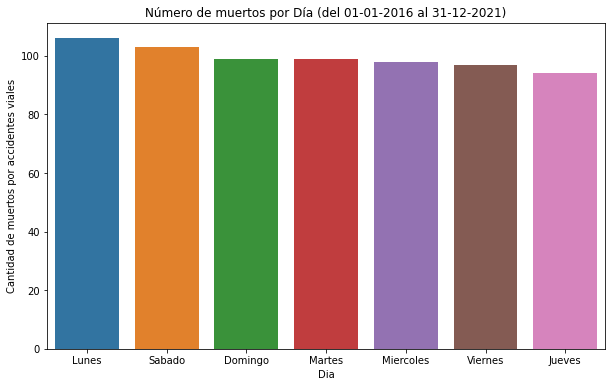

In [63]:
plt.figure(figsize=(10, 6))
sns.countplot(x='dia', data=homicidios, order=homicidios['dia'].value_counts().index)
plt.xlabel("Dia")
plt.ylabel("Cantidad de muertos por accidentes viales")
plt.title("Número de muertos por Día (del 01-01-2016 al 31-12-2021)");

Si bien el dia lunes es el dia con mayor accidentes y el jueves con menor, no hay una tendencia clara debido a que la diferencia entre valores es baja. 

### 1.2.5 Accidentes por mes

In [64]:

homicidios.nunique(axis=0, dropna=True) # observando la fila MM puede verse que se produjeron accidentes mortales durante todos los meses.
mes= homicidios['MM'].value_counts().reset_index()
mes.columns = ['mes', 'cantidad']
mes

,mes,cantidad
0,12,78
1,11,67
2,8,65
3,1,62
4,5,60
5,6,58
6,2,56
7,3,51
8,7,51
9,10,51


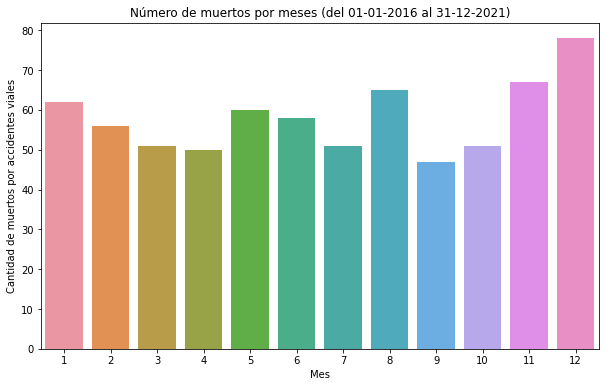

In [66]:
plt.figure(figsize=(10, 6))
sns.countplot(x='MM', data=homicidios)
plt.xlabel("Mes")
plt.ylabel("Cantidad de muertos por accidentes viales")
plt.title("Número de muertos por meses (del 01-01-2016 al 31-12-2021)");

### 1.2.6 Cantidad de accidentes fatales por año

Se grafican los accidentes cada 100000 habitantes.

In [76]:
Anio = homicidios['AAAA'].value_counts().reset_index()
Anio.columns = ['Anio', 'Cantidad']

In [78]:
Anioc100 = homicidios['AAAA'].value_counts().reset_index()
Anioc100.columns = ['Anio', 'Cantidad']
Anioc100.insert(2, 'accidentes/100k', value=Anio['Cantidad']/(ord_al_origen1+m*Anioc100['Anio'])*100000) #Para estimar la poblacion por año se utiliza
                                                                                                        #la formula de la interpolacion lineal 
Anioc100

,Anio,Cantidad,accidentes/100k
0,2016,144,4.791405
1,2018,143,4.698088
2,2017,131,4.331170
3,2019,103,3.362720
4,2021,97,3.127613
5,2020,78,2.530658


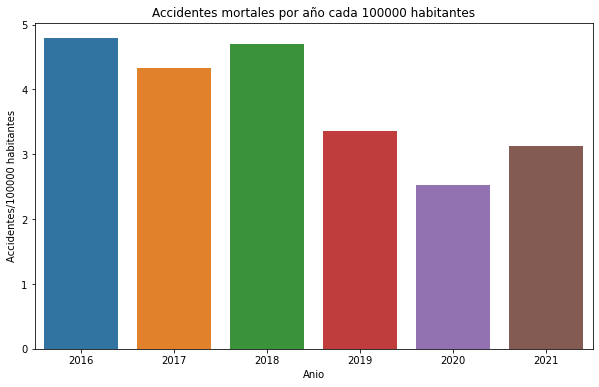

In [81]:
plt.figure(figsize=(10, 6))
sns.barplot(x = "Anio", y = "accidentes/100k", data = Anioc100)
plt.xlabel("Anio")
plt.ylabel("Accidentes/100000 habitantes")
plt.title("Accidentes mortales por año cada 100000 habitantes");

En el gráfico puede verse una disminucion de los accidentes cada 100000 habitantes a lo largo de los años. Observar la baja del año 2020 debida a la disminucion de transito por el aislamiento social preventivo por la pandemia de Covid - 19.

Tener en cuenta que la población año a año es estimada por interpolación lineal entre los datos de los censos de 2010 y 2022.

### 1.2.7 Víctimas por hora del dia

In [30]:
hora = homicidios['HH'].value_counts().reset_index()
hora.columns = ['hora', 'cantidad']
#hora

Text(0.5, 1.0, 'Víctimas por hora del dia')

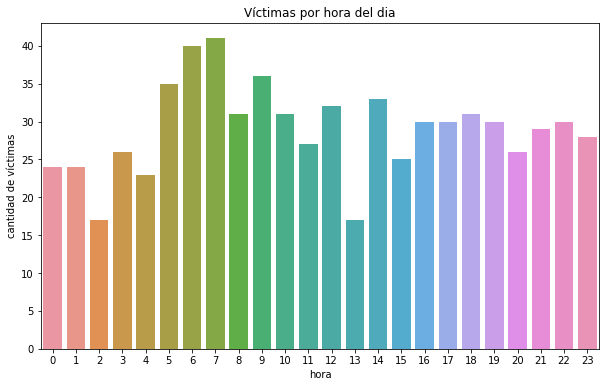

In [31]:
plt.figure(figsize=(10, 6))
sns.barplot(x = "hora", y = "cantidad", data = hora)
plt.xlabel("hora")
plt.ylabel("cantidad de víctimas")
plt.title("Víctimas por hora del dia")

Puede verse un aumento de accidentes en hora pico de la mañana (de 6 a 9). En hora pico de la tarde (16 a 20) hay otro pico aunque no parece verse un aumento tan significativo. 

Tener en cuenta que habia dos registros en la columna HH que tenian de valor 'SD'. Esos valores fueron remplazados por 0 y darian un incremento artificial de accidentes sobre la hora 00:00.

### 1.2.8 Cantidad de accidentes por tipo de vía.

La autopista General Paz figuraba como un tipo de vía. Al tratarse de autopista, en la seccion 1.1 se cambió por autopista.

In [83]:
tipos_de_calle= homicidios['TIPO_DE_CALLE'].value_counts().reset_index()
tipos_de_calle.columns = ['tipo_de_calle', 'cantidad']
tipos_de_calle

,tipo_de_calle,cantidad
0,AVENIDA,429
1,CALLE,136
2,AUTOPISTA,131


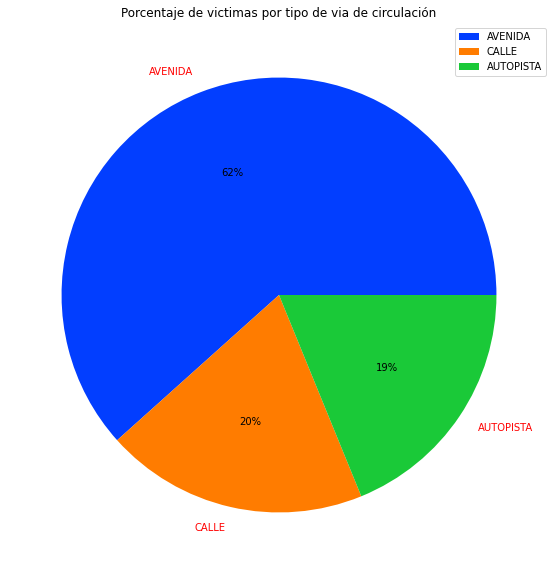

In [84]:
data = tipos_de_calle['cantidad']
labels = tipos_de_calle['tipo_de_calle']
colors = sns.color_palette('bright')
plt.figure(figsize=(10, 10))
# Crear el gráfico de torta
pie = plt.pie(data, labels=labels, colors=colors, autopct='%0.0f%%')
plt.gca().set_facecolor('black')  # Establecer el fondo negro

# Cambiar el color de las etiquetas a blanco
for label in pie[1]:
    label.set_color('red')
plt.legend()
plt.title("Porcentaje de victimas por tipo de via de circulación")
plt.show()

El tipo de via en el que menos accidentes mortales se producen es la autopista.

### 1.2.9 Siniestros en esquinas

De acuerdo a las definiciones del diccionario de los datos, en caso de que el siniestro se haya producido en una esquina, entonces en la columna 'Cruce' deberia verse el nombre de la calle. Puede deducirse entonces que si el registro en esa columna esta en NaN, el siniestro no se produjo entonces en una esquina.


In [85]:

porcentaje_choques_esquinas = homicidios[homicidios['Cruce'].notna()]['Cruce'].count()/len(homicidios['Cruce']) *100
porcentaje_choques_esquinas

75.43103448275862

El 75 % de los siniestros en los que se hubo muertes, se produjeron en esquinas.

### 1.2.10 Cantidad de accidentes por comuna

En la Ciudad de Buenos Aires hay una división política por [comunas](https://buenosaires.gob.ar/comunas). En la planilla de hechos esta especificado en que comuna se produjeron.

In [86]:
comunas= homicidios['COMUNA'].value_counts().reset_index()
comunas.columns = ['comuna', 'cantidad']
comunas = comunas.drop(index=15) # se dropea el index=15 que corresponde a la comuna 0. Esa comuna no existe y ese registro se trata de un error. Para este analisis no es tenido en cuenta ese registro.
comunas

,comuna,cantidad
0,1,90
1,4,76
2,9,73
3,8,65
4,7,60
5,3,45
6,15,44
7,13,40
8,12,37
9,14,35


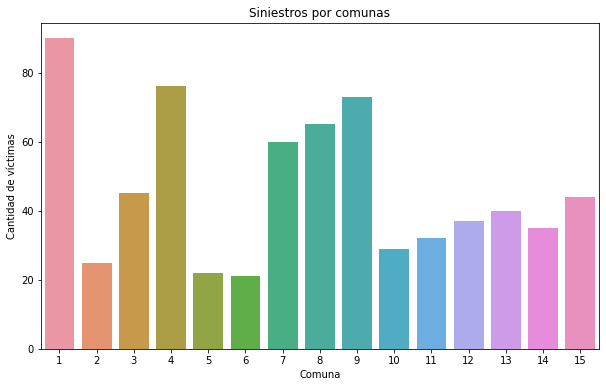

In [88]:
plt.figure(figsize=(10, 6))
sns.barplot(x = "comuna", y = "cantidad", data = comunas)
plt.xlabel("Comuna")
plt.ylabel("Cantidad de víctimas")
plt.title("Siniestros por comunas");

### 1.2.11 Participantes en el siniestro

En el diccionario definen al campo participantes como la conjunción de victima y acusado.

In [90]:

participantes = homicidios['PARTICIPANTES'].value_counts().reset_index()
participantes.columns = ['participantes', 'cantidad']
participantes = participantes.iloc[0:14,:] # dado que son muchas convinaciones posibles, se trunca en los primeros 15
participantes

,participantes,cantidad
0,PEATON-PASAJEROS,105
1,MOTO-AUTO,83
2,MOTO-CARGAS,78
3,PEATON-AUTO,77
4,MOTO-PASAJEROS,46
5,MOTO-OBJETO FIJO,40
6,PEATON-CARGAS,38
7,AUTO-AUTO,31
8,PEATON-MOTO,30
9,MOTO-MOTO,25


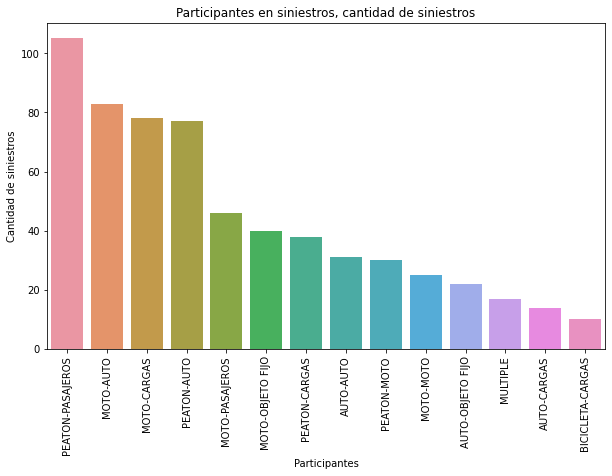

In [91]:
plt.figure(figsize=(10, 6))
sns.barplot(x = "participantes", y = "cantidad", data = participantes)
plt.xlabel("Participantes")
plt.ylabel("Cantidad de siniestros")
plt.title("Participantes en siniestros, cantidad de siniestros")
plt.xticks(rotation=90);

La mayor cantidad de siniestros mortales se producen por la colision de un vehiculo de pasajeros contra un peaton. La diferencia de atropellos de este tipo contra los atropellos de auto contra peaton es notable. Tambien con las colisiones peaton - moto. Las colisiones peaton - moto presentan una siniestralidad similar al la de moto-moto.

### 1.2.12 Victimas del siniestro

Se refiere a las partes afectadas por el siniestro. 

In [93]:
victimas = homicidios['VICTIMA'].value_counts().reset_index()
victimas.columns = ['victimas', 'cantidad']

victimas

,victimas,cantidad
0,MOTO,295
1,PEATON,264
2,AUTO,83
3,BICICLETA,29
4,SD,9
5,CARGAS,7
6,PASAJEROS,5
7,MOVIL,2
8,OBJETO FIJO,1
9,PEATON_MOTO,1


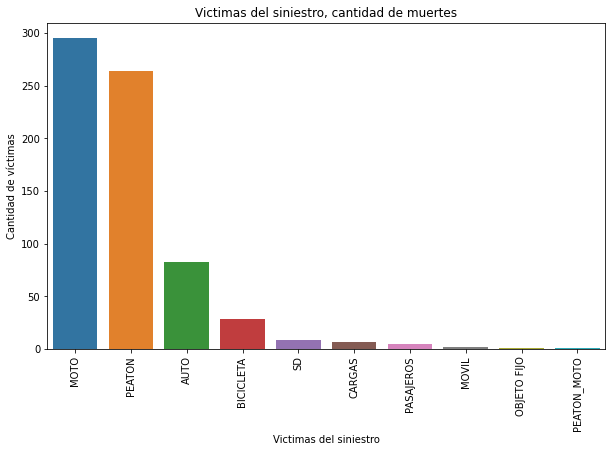

In [91]:
plt.figure(figsize=(10, 6))
sns.barplot(x = "victimas", y = "cantidad", data = victimas)
plt.xlabel("Victimas del siniestro")
plt.ylabel("Cantidad de víctimas")
plt.title("Victimas del siniestro, cantidad de muertes")
plt.xticks(rotation=90);

La mayoria de las victimas en accidentes de transito son motociclistas y peatones.

No confundir con la seccion [1.2.11](#1.2.11-Participantes-en-el-siniestro) en donde cuenta la cantidad de siniestros de cada tipo y en donde el siniestro pasajeros-peaton es el mas numeroso. si se ve en esa misma seccion puede verse que el segundo tipo de siniestro y el tercero involucran a una moto.


### 1.2.13 Acusado del siniestro

Aunque no implique culpabilidad legal se define como quien resulto acusado del siniestro.

In [94]:
acusados = homicidios['ACUSADO'].value_counts().reset_index()
acusados.columns = ['acusado', 'cantidad']
acusados

,acusado,cantidad
0,AUTO,204
1,PASAJEROS,173
2,CARGAS,146
3,OBJETO FIJO,62
4,MOTO,57
5,SD,23
6,MULTIPLE,17
7,BICICLETA,7
8,OTRO,6
9,TREN,1


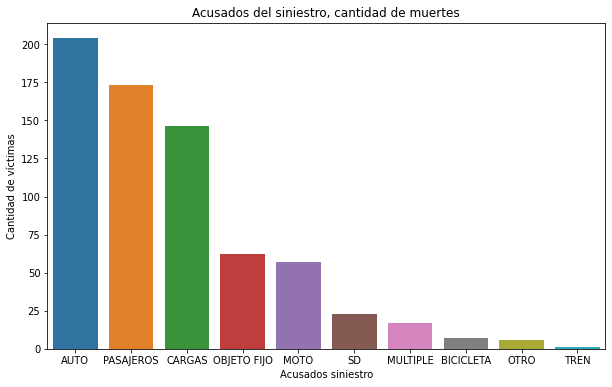

In [96]:
plt.figure(figsize=(10, 6))
sns.barplot(x = "acusado", y = "cantidad", data = acusados)
plt.xlabel("Acusados siniestro")
plt.ylabel("Cantidad de víctimas")
plt.title("Acusados del siniestro, cantidad de muertes");
#plt.xticks(rotation=90);

Puede verse de nuevo aqui la relacion con los graficos anteriores. Donde las motos y los peatones eran las principales víctimas de los accidentes. Ahora bien, los acusados son los autos, vehiculos de pasajeros y de cargas.

# 2. Análisis del Dataframe homicidios_victimas

## 2.1 Transformaciones

Se realizan algunas transformaciones al dataframe, modificando valores erroneos, cambiando de tipos las variables y agregando algunos campos.

In [97]:
homicidios_victimas = pd.read_pickle('homicidios_victimas.pkl')
# se pasan a int los valores de la columna edad. Los valores 'SD' se remplazan por 0 para poder tratar con enteros. son 53 personas aproximadamente.
homicidios_victimas['EDAD'] = homicidios_victimas['EDAD'].replace('SD', 0).astype(int) 


#Se genera una nueva columna con el rango etario. para la eleccion de los rangos se consira esto: https://economipedia.com/definiciones/segmentacion-por-edad.html 
# y ademas que en argentinapara poder sacar registro de conduccion de moto es necesario tener mas de 16 años.
bins = [0, 16, 27, 40, 60, 80, 120]  # Límites de los intervalos
etiquetas = ['menor de 16', 'entre 16 y 27', 'entre 27 y 40', 'entre 40 y 60', 'entre 60 y 75', 'mayor de 75']  # Etiquetas para cada intervalo


homicidios_victimas.insert(9,column='rango_etario', value='a')
homicidios_victimas['rango_etario'] = pd.cut(homicidios_victimas['EDAD'], bins=bins, labels=etiquetas, right=True, ordered=False)

## 2.2 Análisis de los campos de la tabla homicidios victimas

### 2.2.1 ID_hecho

Este campo contiene los ID de la tabla de hechos analizada con anterioridad. Pueden verse valores repetidos y eso es porque como se vio antes, en todos los accidentes registrados se han producido víctimas, pero en algunos casos el numero es mayor a 1.

In [102]:
print('Cantidad de registros de ID sin repetir: ', homicidios_victimas['ID_hecho'].unique().size, ', cantidad de registros totales: ', len(homicidios_victimas))

Cantidad de registros de ID sin repetir:  696 , cantidad de registros totales:  717


### 2.2.2 Fecha

Al igual que en la tabla anterior, los datos del dataframe homicidios_victimas  van desde:  2016-01-01 hasta:  2021-12-30

In [93]:
print('Los datos del dataframe homicidios_victimas  van desde: ', homicidios_victimas.FECHA.min(), 'hasta: ', homicidios_victimas.FECHA.max())

Los datos del dataframe homicidios_victimas  van desde:  2016-01-01 00:00:00 hasta:  2021-12-30 00:00:00


In [94]:
print('desde: ', min(homicidios_victimas['AAAA']), 'hasta: ', max(homicidios_victimas['AAAA']))

desde:  2016 hasta:  2021


In [95]:
print('mes min: ', min(homicidios_victimas['MM']), 'mes max: ', max(homicidios_victimas['MM']), 'dia min: ', min(homicidios_victimas['DD']), 'max dia: ', max(homicidios_victimas['DD']))

mes min:  1 mes max:  12 dia min:  1 max dia:  31


### 2.2.3 Rol de las víctimas en el siniestro

In [117]:
rol = homicidios_victimas['ROL'].value_counts().reset_index()
rol.columns = ['rol', 'cantidad']
rol

,rol,cantidad
0,CONDUCTOR,330
1,PEATON,267
2,PASAJERO_ACOMPAÑANTE,80
3,CICLISTA,29
4,SD,11


In [122]:
print('La cantidad de victimas conductores que conducian una moto es : ', homicidios_victimas.loc[(homicidios_victimas['ROL']=='CONDUCTOR') & (homicidios_victimas['VICTIMA']=='MOTO')].count()[0])

La cantidad de victimas conductores que conducian una moto es :  261


De los 330 muertos conductores, la mayoría (261/330) conducían motos, con lo cual se verifica lo comentado en el otro dataframe en la columna Victima del siniestro.

### 2.2.4 Sexo de las victimas

In [124]:
rol = homicidios_victimas['SEXO'].value_counts().reset_index()
rol.columns = ['sexo', 'cantidad']
rol

,sexo,cantidad
0,MASCULINO,545
1,FEMENINO,166
2,SD,6


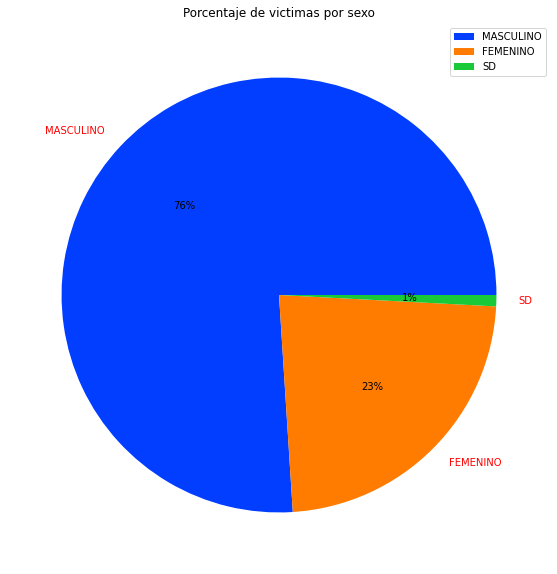

In [125]:
data = rol['cantidad']
labels = rol['sexo']
colors = sns.color_palette('bright')
plt.figure(figsize=(10, 10))
# Crear el gráfico de torta
pie = plt.pie(data, labels=labels, colors=colors, autopct='%0.0f%%')
plt.gca().set_facecolor('black')  # Establecer el fondo negro

# Cambiar el color de las etiquetas a blanco
for label in pie[1]:
    label.set_color('red')
plt.legend()
plt.title("Porcentaje de victimas por sexo")
plt.show()

### 2.2.5 Edad de las víctimas

Habrá que tene una consideracion aqui y es que en algunos registros la edad no estaba registrada. En la seccion [transformaciones](#2.1-Transformaciones) se cambiaron esos valores faltantes por 0. En total se realizaron 53 transformaciones.

In [98]:
homicidios_victimas['EDAD'].loc[homicidios_victimas['EDAD']==0].count()

53

In [99]:
homicidios_victimas['EDAD'].describe() # este describe puede un poco de error por lo mencionado anteriormente

count    717.000000
mean      39.050209
std       22.010669
min        0.000000
25%       24.000000
50%       35.000000
75%       55.000000
max       95.000000
Name: EDAD, dtype: float64

### 2.2.6 Rango etario de las victimas victimas (parte afectada del accidente) y vehículo de la victima
Esta columna fue creada en la seccion [transformaciones](#2.1-Transformaciones) considerando las definiciones de  [economipedia](https://economipedia.com/definiciones/segmentacion-por-edad.html) y ademas considerando que la edad mínima para tener un registro de conducir es de 16 años para moto y 17 años para vehiculos particulares.

In [28]:
rango_etario = homicidios_victimas['rango_etario'].value_counts().reset_index()
rango_etario.columns = ['rango_etario', 'cantidad']
rango_etario

,rango_etario,cantidad
0,entre 27 y 40,201
1,entre 40 y 60,162
2,entre 16 y 27,159
3,entre 60 y 75,94
4,mayor de 75,30
5,menor de 16,18


In [101]:
victimas = homicidios_victimas['VICTIMA'].value_counts().reset_index()
victimas.columns = ['victima', 'cantidad']
victimas

,victima,cantidad
0,MOTO,303
1,PEATON,267
2,AUTO,94
3,BICICLETA,29
4,SD,9
5,CARGAS,7
6,PASAJEROS,5
7,MOVIL,3


En el siguiente grafico puede verse el vehiculo de la victima por rango etario.

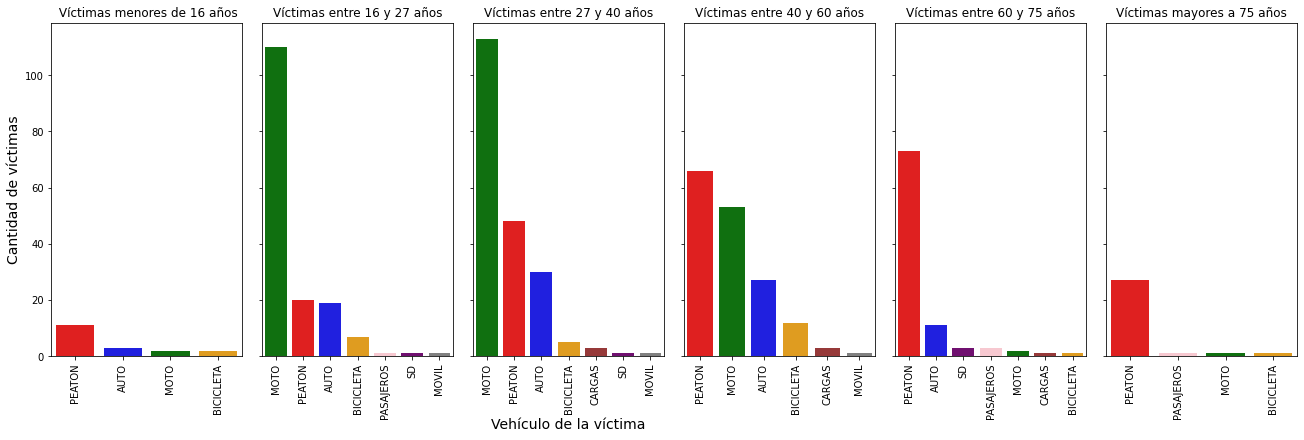

In [47]:
rango0 = homicidios_victimas.loc[(homicidios_victimas['rango_etario']== 'menor de 16')]
rol0 = rango0['VICTIMA'].value_counts().reset_index()
rol0.columns = ['victima', 'cantidad']

rango1 = homicidios_victimas.loc[(homicidios_victimas['rango_etario']== 'entre 16 y 27')]
rol1 = rango1['VICTIMA'].value_counts().reset_index()
rol1.columns = ['victima', 'cantidad']

rango2 = homicidios_victimas.loc[(homicidios_victimas['rango_etario']== 'entre 27 y 40')]
rol2 = rango2['VICTIMA'].value_counts().reset_index()
rol2.columns = ['victima', 'cantidad']

rango3 = homicidios_victimas.loc[(homicidios_victimas['rango_etario']== 'entre 40 y 60')]
rol3 = rango3['VICTIMA'].value_counts().reset_index()
rol3.columns = ['victima', 'cantidad']

rango4 = homicidios_victimas.loc[(homicidios_victimas['rango_etario']== 'entre 60 y 75')]
rol4 = rango4['VICTIMA'].value_counts().reset_index()
rol4.columns = ['victima', 'cantidad']


rango5 = homicidios_victimas.loc[(homicidios_victimas['rango_etario']== 'mayor de 75')]
rol5 = rango5['VICTIMA'].value_counts().reset_index()
rol5.columns = ['victima', 'cantidad']

colores = {"AUTO": "blue", "MOTO": "green", "PEATON": "red", "BICICLETA": "orange", 'SD': "purple", 'CARGAS': "brown", 'PASAJEROS': "pink", 'MOVIL': "gray"}
#fig, axs = plt.subplots(1,2, figsize=(3,3))
fig, axs = plt.subplots(1, 6, figsize=(18, 6), sharey=True, constrained_layout=True)



sns.barplot(x="victima", y="cantidad", data=rol0, ax=axs[0], palette=colores)
axs[0].set_xlabel(" ")
axs[0].set_ylabel("Cantidad de víctimas", fontsize=14)
axs[0].set_title(" Víctimas menores de 16 años")

sns.barplot(x="victima", y="cantidad", data=rol1, ax=axs[1], palette=colores)
axs[1].set_xlabel(" ")
axs[1].set_ylabel(" ")
axs[1].set_title("Víctimas entre 16 y 27 años")


sns.barplot(x = "victima", y = "cantidad", data=rol2, ax=axs[2], palette=colores)
axs[2].set_xlabel("Vehículo de la víctima", fontsize=14)
axs[2].set_ylabel(" ")
axs[2].set_title("Víctimas entre 27 y 40 años");


sns.barplot(x = "victima", y = "cantidad", data=rol3, ax=axs[3], palette=colores)
axs[3].set_xlabel(" ")
axs[3].set_ylabel(" ")
axs[3].set_title("Víctimas entre 40 y 60 años");


sns.barplot(x = "victima", y = "cantidad", data=rol4, ax=axs[4], palette=colores)
axs[4].set_xlabel(" ")
axs[4].set_ylabel(" ")
axs[4].set_title("Víctimas entre 60 y 75 años");


sns.barplot(x = "victima", y = "cantidad", data=rol5, ax=axs[5], palette=colores)
axs[5].set_xlabel(" ")
axs[5].set_ylabel(" ")
axs[5].set_title("Víctimas mayores a 75 años");



for ax in axs:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

#plt.tight_layout()

plt.show()




En este grafico puede verse las victimas segun el rango etario. En el rango de 16 a 27 años ("adolescentes") puede verse la gran diferencia de la principal causa de muerte respecto al rango que sigue de 27 a 40 años. Si bien en ambos es la moto, en el segundo caso la diferencia con respecto a peaton y a auto es mucho menor.